tgb - 1/6/2020 - The goal of this notebook is to target the residual to in the loss of ACnets to avoid the under-performance of the network at the residual level (following-up notebook 020 [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/020_Sensitivity_Residual_level_Conservation.ipynb]). The steps will be to:  
1) Implement the ACnet with residuals at mid-level following notebook 020  
2) Modify the loss by introducing a scale_dic with targeted weighting at the residual level with different multipliers  
3) Compare the squared-error to check if the method works

tgb - 6/23/2020 - Adapting the notebook for hyperparameter optimization run by Jordan. Additionally to the hyperparameters listed in [https://arxiv.org/pdf/1909.00912.pdf], the hyperparameter search now includes the "residual index" and beta, a weight in the loss function meant to decrease the bias at the "residual index".

# 0) Imports

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
#import tensorflow.math as tfm
from tensorflow import math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics

#limit_mem() # Otherwise tensorflow will use ALL your GPU RAM for no reason

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


In [2]:
PREFIX = '8col009_01_' # Filename prefix 

Change paths below to adapt to your environment

In [3]:
# Folder where training/validation data are stored
#TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
TRAINDIR = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/' 

# cd into cloned github repository
#%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
%cd /export/home/tbeucler/CBRAIN-CAM 

/nfspool-0/home/tbeucler/CBRAIN-CAM


# 1) Custom layers and loss

## 1.1) Define custom "constraints" layers
Copied over from [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/020_Sensitivity_Residual_level_Conservation.ipynb]

Mass conservation layer (introduces hyper-parameter `lvl_choice` for residual index)

In [4]:
class MassConsLayer_choice(Layer):
    def __init__(self, inp_sub, inp_div, norm_q, hyai, hybi, lvl_choice, **kwargs):
        """
        Call using ([input, output])
        Assumes
        prior: [PHQ_nores, PHCLDLIQ, PHCLDICE, TPHYSTND_nores,
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Returns
        post(erior): [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND_nores,
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Added lvl_choice, a hyper-parameter to choose the level of mass conservation [0-29]
        """
        self.inp_sub, self.inp_div, self.norm_q, self.hyai, self.hybi = \
            np.array(inp_sub), np.array(inp_div), np.array(norm_q), np.array(hyai), np.array(hybi)
        self.lvl_choice = np.int32(lvl_choice)
        # Define variable indices here
        # Input
        self.PS_idx = 300
        self.LHFLX_idx = 303
        # Output
        self.PHQbef_idx = slice(0, self.lvl_choice) # Indices before the residual
        self.PHCLDLIQ_idx = slice(29, 59)
        self.PHCLDICE_idx = slice(59, 89)
        self.PRECT_idx = 212
        self.PRECTEND_idx = 213

        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def get_config(self):
        config = {'inp_sub': list(self.inp_sub), 'inp_div': list(self.inp_div),
                  'norm_q': list(self.norm_q), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi), 'lvl_choice':self.lvl_choice}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, arrs):
        inp, prior = arrs

        # 1. Compute dP_tilde
        dP_tilde = compute_dP_tilde(
            inp[:, self.PS_idx],
            self.inp_div[self.PS_idx], self.inp_sub[self.PS_idx],
            self.norm_q, self.hyai, self.hybi
        )

        # 2. Compute vertical cloud water integral
        CLDINT = K.sum(dP_tilde *
                       (prior[:, self.PHCLDLIQ_idx] + prior[:, self.PHCLDICE_idx]),
                       axis=1)

        # 3. Compute water vapor integral minus the water vapor residual
        # Careful with handling the pressure vector since it is not aligned
        # with the prior water vapor vector
        VAPINT = K.sum(dP_tilde[:, self.PHQbef_idx] * prior[:, self.PHQbef_idx], 1) +\
        K.sum(dP_tilde[:, self.lvl_choice+1:30] * prior[:, self.lvl_choice:29], 1)

        # 4. Compute forcing (see Tom's note for details, I am just copying)
        LHFLX = (inp[:, self.LHFLX_idx] * self.inp_div[self.LHFLX_idx] +
                 self.inp_sub[self.LHFLX_idx])
        PREC = prior[:, self.PRECT_idx] + prior[:, self.PRECTEND_idx]

        # 5. Compute water vapor tendency at level lvl_choice as residual
        PHQ_LVL = (LHFLX - PREC - CLDINT - VAPINT) / dP_tilde[:, self.lvl_choice]

        # 6. Concatenate output vector
        post = tf.concat([
            prior[:, self.PHQbef_idx], PHQ_LVL[:, None],
            prior[:, self.lvl_choice:]
        ], axis=1)
        return post

    def compute_output_shape(self, input_shape):
        """Input shape + 1"""
        return (input_shape[0][0], input_shape[0][1] + 1)

Enthalpy conservation layer (introduces hyper-parameter `lvl_choice` for residual index)

In [5]:
class EntConsLayer_choice(Layer):
    def __init__(self, inp_sub, inp_div, norm_q, hyai, hybi, lvl_choice, **kwargs):
        """
        Call using ([input, output])
        Assumes
        prior: [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND_nores,
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Returns
        post(erior): [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND,
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        """
        self.inp_sub, self.inp_div, self.norm_q, self.hyai, self.hybi = \
            np.array(inp_sub), np.array(inp_div), np.array(norm_q), np.array(hyai), np.array(hybi)
        self.lvl_choice = np.int32(lvl_choice)
        # Define variable indices here
        # Input
        self.PS_idx = 300
        self.SHFLX_idx = 302
        self.LHFLX_idx = 303

        # Output
        self.PHQ_idx = slice(0, 30)
        self.PHCLDLIQ_idx = slice(30, 60)
        self.Tbef_idx = slice(90, 90+self.lvl_choice)
        self.DTVKE_idx = slice(179, 209)
        self.FSNT_idx = 209
        self.FSNS_idx = 210
        self.FLNT_idx = 211
        self.FLNS_idx = 212
        self.PRECT_idx = 213
        self.PRECTEND_idx = 214
        self.PRECST_idx = 215
        self.PRECSTEND_idx = 216

        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def get_config(self):
        config = {'inp_sub': list(self.inp_sub), 'inp_div': list(self.inp_div),
                  'norm_q': list(self.norm_q), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi), 'lvl_choice': self.lvl_choice}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, arrs):
        inp, prior = arrs

        # 1. Compute dP_tilde
        dP_tilde = compute_dP_tilde(
            inp[:, self.PS_idx],
            self.inp_div[self.PS_idx], self.inp_sub[self.PS_idx],
            self.norm_q, self.hyai, self.hybi
        )

        # 2. Compute net energy input from phase change and precipitation
        PHAS = L_I / L_V * (
                (prior[:, self.PRECST_idx] + prior[:, self.PRECSTEND_idx]) -
                (prior[:, self.PRECT_idx] + prior[:, self.PRECTEND_idx])
        )

        # 3. Compute net energy input from radiation, SHFLX and TKE
        RAD = (prior[:, self.FSNT_idx] - prior[:, self.FSNS_idx] -
               prior[:, self.FLNT_idx] + prior[:, self.FLNS_idx])
        SHFLX = (inp[:, self.SHFLX_idx] * self.inp_div[self.SHFLX_idx] +
                 self.inp_sub[self.SHFLX_idx])
        KEDINT = K.sum(dP_tilde * prior[:, self.DTVKE_idx], 1)

        # 4. Compute tendency of vapor due to phase change
        LHFLX = (inp[:, self.LHFLX_idx] * self.inp_div[self.LHFLX_idx] +
                 self.inp_sub[self.LHFLX_idx])
        VAPINT = K.sum(dP_tilde * prior[:, self.PHQ_idx], 1)
        SPDQINT = (VAPINT - LHFLX) * L_S / L_V

        # 5. Same for cloud liquid water tendency
        SPDQCINT = K.sum(dP_tilde * prior[:, self.PHCLDLIQ_idx], 1) * L_I / L_V

        # 6. And the same for T but remember residual is still missing
        DTINT = K.sum(dP_tilde[:, :self.lvl_choice] *\
                      prior[:, self.Tbef_idx], 1) +\
        K.sum(dP_tilde[:, self.lvl_choice+1:30] *\
             prior[:, 90+self.lvl_choice:119], 1)

        # 7. Compute DT30 as residual
        DT_LVL = (
                       PHAS + RAD + SHFLX + KEDINT - SPDQINT - SPDQCINT - DTINT
               ) / dP_tilde[:, self.lvl_choice]

        # 8. Concatenate output vector
        post = tf.concat([
            prior[:, :(90+self.lvl_choice)], DT_LVL[:, None], \
            prior[:, (90+self.lvl_choice):]
        ], axis=1)
        return post

    def compute_output_shape(self, input_shape):
        """Input shape + 1"""
        return (input_shape[0][0], input_shape[0][1] + 1)

## 1.2) Define custom loss
Introducing hyper-parameter `beta` to give additional weight to residual indices (at levels `lev1` and `lev2` in the loss)

In [6]:
class Weighted_Loss():
    def __init__(self, lev1, lev2, beta, name='weighted_loss',**kwargs):
        self.lev1 = lev1
        self.lev2 = lev2
        self.beta = beta
        self.__name__ = name
        super().__init__(**kwargs)
    def __call__(self,ytrue,ypred):
        # Multiply two levels of y_pred by beta
        ypred_mult = tf.concat([
            ypred[:,:self.lev1],
            tf.expand_dims(self.beta*ypred[:,self.lev1],axis=1),
            ypred[:,self.lev1:self.lev2],
            tf.expand_dims(self.beta*ypred[:,self.lev2],axis=1),
            ypred[:,self.lev2:]
        ], axis=1)
        # Multiply two levels of y_truth by beta
        ytrue_mult = tf.concat([
            ytrue[:,:self.lev1],
            tf.expand_dims(self.beta*ytrue[:,self.lev1],axis=1),
            ytrue[:,self.lev1:self.lev2],
            tf.expand_dims(self.beta*ytrue[:,self.lev2],axis=1),
            ytrue[:,self.lev2:]
        ], axis=1)
        return (ypred_mult-ytrue_mult)**2

# 2) Build neural networks

## 2.1) Define data generators

In [12]:
scale_dict = load_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl')
in_vars = load_pickle('./nn_config/scale_dicts/009_Wm2_in_vars.pkl')
out_vars = load_pickle('./nn_config/scale_dicts/009_Wm2_out_vars.pkl')
dP = load_pickle('./nn_config/scale_dicts/009_Wm2_dP.pkl')

In [13]:
train_gen = DataGenerator(
    data_fn = TRAINDIR+PREFIX+'train_shuffle.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+PREFIX+'norm.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)
valid_gen = DataGenerator(
    data_fn = TRAINDIR+PREFIX+'valid.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+PREFIX+'norm.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=False
)
test_gen = DataGenerator(
    data_fn = TRAINDIR+PREFIX+'test.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+PREFIX+'norm.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=False
)

## 2.2) Define models

In [14]:
def Conserving_Model(maslevel,entlevel):
    inpC = Input(shape=(304,))
    densout = Dense(512, activation='linear')(inpC)
    densout = LeakyReLU(alpha=0.3)(densout)
    for i in range (4):
        densout = Dense(512, activation='linear')(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    densout = Dense(214, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
    surfout = SurRadLayer(
        inp_div=train_gen.input_transform.div,
        inp_sub=train_gen.input_transform.sub,
        norm_q=scale_dict['PHQ'],
        hyai=hyai, hybi=hybi
    )([inpC, densout])
    massout = MassConsLayer_choice(
        inp_div=train_gen.input_transform.div,
        inp_sub=train_gen.input_transform.sub,
        norm_q=scale_dict['PHQ'],
        hyai=hyai, hybi=hybi\
        , lvl_choice=maslevel
    )([inpC, surfout])
    enthout = EntConsLayer_choice(
        inp_div=train_gen.input_transform.div,
        inp_sub=train_gen.input_transform.sub,
        norm_q=scale_dict['PHQ'],
        hyai=hyai, hybi=hybi\
        , lvl_choice=entlevel
    )([inpC, massout])
    return tf.keras.models.Model(inpC, enthout)

Add callback to stop in case the validation loss doesn't decrease anymore

In [10]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

## 2.3) Train models

In [12]:
Nep = 20
beta_array = np.array([20,10,5,2,1]) # In this example, I loop over values of beta

NN = {}
for i,beta in enumerate(beta_array):
    
    # "Residual indices" defined here
    imres = 14; # Mass residual index
    ieres = 14; # Enthalpy residual index
    
    print('beta=',beta,'Mas index=',str(imres),' & Ent index=',str(ieres))
    graph = tf.Graph()
    with tf.Session(graph=graph):

        # 1) Create model
        # ACnet with mass residual index = imres
        # and enthalpy residual index = ieres
        NN = Conserving_Model(imres,ieres)
        print('NN is ',NN.summary())

        # 2) Compile model with custom loss of custom weight beta
        NN.compile(tf.keras.optimizers.RMSprop(), 
                   loss=Weighted_Loss(lev1=imres,lev2=90+ieres,beta=beta))

        # 3) Train and save model
        path = TRAINDIR+'HDF5_DATA/Cm{mlev}_e{elev}_beta{beta}.hdf5'.format(
            mlev = imres, elev = ieres, beta=beta) # Path where model is saved
        mcp_save = ModelCheckpoint(path,save_best_only=True,\
                                   monitor='val_loss', mode='min')
        NN.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen,\
                        callbacks=[earlyStopping, mcp_save])
        print('NN saved in ',path)

beta= 20 Mas index= 14  & Ent index= 14
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 304)          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          156160      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      leaky_re_lu[0][0]              

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



# 3) Compare squared errors and constraints penalty of vertical profiles

## 3.1) Mass/energy/radiation checkers

From notebook [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/041_ACnet_Non_Linear.ipynb]

In [7]:
def mass_res_diagno(inp_div,inp_sub,norm_q,inp,pred):
    # Input
    PS_idx = 300
    LHFLX_idx = 303

    # Output
    PHQ_idx = slice(0, 30)
    PHCLDLIQ_idx = slice(30, 60)
    PHCLDICE_idx = slice(60, 90)
    PRECT_idx = 214
    PRECTEND_idx = 215

    # 1. Compute dP_tilde
    dP_tilde = compute_dP_tilde(inp[:, PS_idx],  inp_div[PS_idx], inp_sub[PS_idx], norm_q, hyai, hybi)

    # 2. Compute water integral
    WATINT = np.sum(dP_tilde *(pred[:, PHQ_idx] + pred[:, PHCLDLIQ_idx] + pred[:, PHCLDICE_idx]), axis=1)
#     print('PHQ',np.mean(np.sum(dP_tilde*pred[:,PHQ_idx],axis=1)))
#     print('PHCLQ',np.mean(np.sum(dP_tilde*pred[:,PHCLDLIQ_idx],axis=1)))
#     print('PHICE',np.mean(np.sum(dP_tilde*pred[:,PHCLDICE_idx],axis=1)))

    # 3. Compute latent heat flux and precipitation forcings
    LHFLX = inp[:, LHFLX_idx] * inp_div[LHFLX_idx] + inp_sub[LHFLX_idx]
    PREC = pred[:, PRECT_idx] + pred[:, PRECTEND_idx]

    # 4. Compute water mass residual
#     print('LHFLX',np.mean(LHFLX))
#     print('PREC',np.mean(PREC))
#     print('WATINT',np.mean(WATINT))
    WATRES = LHFLX - PREC - WATINT
    #print('WATRES',np.mean(WATRES))

    return np.square(WATRES)

In [8]:
def ent_res_diagno(inp_div,inp_sub,norm_q,inp,pred):

    # Input
    PS_idx = 300
    SHFLX_idx = 302
    LHFLX_idx = 303

    # Output
    PHQ_idx = slice(0, 30)
    PHCLDLIQ_idx = slice(30, 60)
    PHCLDICE_idx = slice(60, 90)
    TPHYSTND_idx = slice(90, 120)
    DTVKE_idx = slice(180, 210)
    FSNT_idx = 210
    FSNS_idx = 211
    FLNT_idx = 212
    FLNS_idx = 213
    PRECT_idx = 214
    PRECTEND_idx = 215
    PRECST_idx = 216
    PRECSTEND_idx = 217

    # 1. Compute dP_tilde
    dP_tilde = compute_dP_tilde(inp[:, PS_idx],  inp_div[PS_idx], inp_sub[PS_idx], norm_q, hyai, hybi)

    # 2. Compute net energy input from phase change and precipitation
    PHAS = L_I / L_V * (
            (pred[:, PRECST_idx] + pred[:, PRECSTEND_idx]) -
            (pred[:, PRECT_idx] + pred[:, PRECTEND_idx])
    )

    # 3. Compute net energy input from radiation, SHFLX and TKE
    RAD = (pred[:, FSNT_idx] - pred[:, FSNS_idx] -
           pred[:, FLNT_idx] + pred[:, FLNS_idx])
    SHFLX = (inp[:, SHFLX_idx] * inp_div[SHFLX_idx] +
             inp_sub[SHFLX_idx])
    KEDINT = np.sum(dP_tilde * pred[:, DTVKE_idx], 1)

    # 4. Compute tendency of vapor due to phase change
    LHFLX = (inp[:, LHFLX_idx] * inp_div[LHFLX_idx] +
             inp_sub[LHFLX_idx])
    VAPINT = np.sum(dP_tilde * pred[:, PHQ_idx], 1)
    SPDQINT = (VAPINT - LHFLX) * L_S / L_V

    # 5. Same for cloud liquid water tendency
    SPDQCINT = np.sum(dP_tilde * pred[:, PHCLDLIQ_idx], 1) * L_I / L_V

    # 6. And the same for T but remember residual is still missing
    DTINT = np.sum(dP_tilde * pred[:, TPHYSTND_idx], 1)

    # 7. Compute enthalpy residual
    ENTRES = SPDQINT + SPDQCINT + DTINT - RAD - SHFLX - PHAS - KEDINT

    return np.square(ENTRES)

In [9]:
def lw_res_diagno(inp_div,inp_sub,norm_q,inp,pred):

    # Input
    PS_idx = 300

    # Output
    QRL_idx = slice(120, 150)
    FLNS_idx = 213
    FLNT_idx = 212

    # 1. Compute dP_tilde
    dP_tilde = compute_dP_tilde(inp[:, PS_idx],  inp_div[PS_idx], inp_sub[PS_idx], norm_q, hyai, hybi)

    # 2. Compute longwave integral
    LWINT = np.sum(dP_tilde *pred[:, QRL_idx], axis=1)

    # 3. Compute net longwave flux from lw fluxes at top and bottom
    LWNET = pred[:, FLNS_idx] - pred[:, FLNT_idx]

    # 4. Compute water mass residual
    LWRES = LWINT-LWNET

    return np.square(LWRES)

def sw_res_diagno(inp_div,inp_sub,norm_q,inp,pred):

    # Input
    PS_idx = 300

    # Output
    QRS_idx = slice(150, 180)
    FSNS_idx = 211
    FSNT_idx = 210

    # 1. Compute dP_tilde
    dP_tilde = compute_dP_tilde(inp[:, PS_idx],  inp_div[PS_idx], inp_sub[PS_idx], norm_q, hyai, hybi)

    # 2. Compute longwave integral
    SWINT = np.sum(dP_tilde *pred[:, QRS_idx], axis=1)

    # 3. Compute net longwave flux from lw fluxes at top and bottom
    SWNET = pred[:, FSNT_idx] - pred[:, FSNS_idx]

    # 4. Compute water mass residual
    SWRES = SWINT-SWNET

    return np.square(SWRES)

In [10]:
def tot_res_diagno(inp_div,inp_sub,norm_q,inp,pred):
    return 0.25*(mass_res_diagno(inp_div,inp_sub,norm_q,inp,pred)+\
                ent_res_diagno(inp_div,inp_sub,norm_q,inp,pred)+\
                lw_res_diagno(inp_div,inp_sub,norm_q,inp,pred)+\
                sw_res_diagno(inp_div,inp_sub,norm_q,inp,pred))

## 3.2) Load models

In [19]:
multiplier = 1
mult_array = np.array([1,2,5,10,20])
end_array = ['_2','_2','','','']
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
           'MassConsLayer_choice':MassConsLayer_choice,'EntConsLayer_choice':EntConsLayer_choice,
           'Conserving_Model':Conserving_Model,'weighted_loss':Weighted_Loss(lev1=14,lev2=104,beta=1)}

In [22]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for im,multiplier in enumerate(mult_array):
    print('Multiplier is ',multiplier)
    path = TRAINDIR+'../HDF5_DATA/Cm14_e14_multiplier'+str(multiplier)+end_array[im]+'.hdf5'
    NN[multiplier] = load_model(path,custom_objects=dict_lay,compile=False)

[Errno 2] No such file or directory: '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS//HDF5_DATA'
/nfspool-0/home/tbeucler/CBRAIN-CAM
Multiplier is  1
Multiplier is  2
Multiplier is  5
Multiplier is  10
Multiplier is  20


## 3.3) Calculate squared error and physical constraints resid

In [36]:
gen = valid_gen

In [37]:
SE = {}
TRES = {}
MSE = {}
MEAN = {}
SQMEAN = {}

In [38]:
spl = 0
while gen[spl][0].size>0: #spl is sample number
    
    print('spl=',spl,'                  ',end='\r')
    
    inp = gen[spl][0]
    truth = gen[spl][1]
    
    for im,multiplier in enumerate(mult_array):
        pred = NN[multiplier].predict_on_batch(inp)
        #pred[:,14] /= multiplier
        #pred[:,104] /= multiplier

        se = (pred-truth)**2

        pred_phys = pred/gen.output_transform.scale

        tresid = tot_res_diagno(gen.input_transform.div,gen.input_transform.sub,
                                gen.output_transform.scale[:30],inp,pred)

        if spl==0: 
            SE[multiplier] = se; TRES[multiplier] = tresid; MSE[multiplier] = np.mean(se,axis=1);
            MEAN[multiplier] = truth; SQMEAN[multiplier] = truth**2;
        else: 
            SE[multiplier] += se; 
            TRES[multiplier] = np.concatenate((TRES[multiplier],tresid),axis=0); 
            MSE[multiplier] = np.concatenate((MSE[multiplier],np.mean(se,axis=1)),axis=0);
            MEAN[multiplier] += truth; SQMEAN[multiplier] += truth**2;

    spl += 1
    


In [39]:
for imultiplier,multiplier in enumerate(mult_array): 
    SE[multiplier] /= spl
    MEAN[multiplier] /= spl
    SQMEAN[multiplier] /= spl

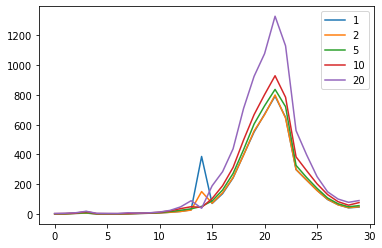

In [40]:
for imultiplier,multiplier in enumerate(mult_array):
    plt.plot(np.mean(SE[multiplier][:,90:120],axis=0),label=str(multiplier))
plt.legend()

In [41]:
VAR = {}
R2p = {}

In [42]:
for imultiplier,multiplier in enumerate(mult_array):
    VAR[multiplier] = SQMEAN[multiplier]-MEAN[multiplier]**2
    R2p[multiplier] = 1-SE[multiplier]/VAR[multiplier]

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


## 3.4) Save reduced data in PKL format

In [43]:
#pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

In [44]:
hf = open(pathPKL+'2020_10_25_validgen036.pkl','wb')
S = {"TRES":TRES,"MSE":MSE,"SE":SE,"MEAN":MEAN,"SQMEAN":SQMEAN,"VAR":VAR,"R2p":R2p}
pickle.dump(S,hf)
hf.close()

# 4) Calculate performance of NNs sent by Jordan during new HP optimization

In [7]:
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
           'MassConsLayer_choice':MassConsLayer_choice,'EntConsLayer_choice':EntConsLayer_choice,
           'weighted_loss':Weighted_Loss(lev1=14,lev2=104,beta=1)}
config_fn = '/export/home/tbeucler/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'

In [8]:
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'

In [9]:
path_model = path_HDF5+'00078.h5'

In [10]:
NN = load_model(path_model,custom_objects=dict_lay)

In [11]:
REs = 'mdres'; 
FOR = 'hdf5'
DATASET = ['valid']
#NNarray = ['00078','00098','00108','00210','00233']
NNarray = ['00210','00233']

In [12]:
def get_truth_pred_J(self, itime, var=None):
    X, truth = self.valid_gen[itime]
    pred = self.model.predict_on_batch(X.values)
    # Inverse transform
    truth = self.valid_gen.output_transform.inverse_transform(truth.values)
    pred = self.valid_gen.output_transform.inverse_transform(pred)

    if var is not None:
        var_idxs = self.get_output_var_idx(var)
        truth = truth[:, var_idxs]
        pred = pred[:, var_idxs]

    return self.reshape_ngeo(truth), self.reshape_ngeo(pred)

def compute_stats_J(self, niter=None):
    """Compute statistics in for [lat, lon, var, lev]"""
    nt = self.valid_gen.n_batches
    if niter is not None: nt = niter
    # Allocate stats arrays
    psum = np.zeros((self.nlat, self.nlon, self.valid_gen.n_outputs))
    tsum = np.copy(psum)
    sse = np.copy(psum)
    psqsum = np.copy(psum)
    tsqsum = np.copy(psum)
    for itime in tqdm(range(nt)):
        t, p = get_truth_pred_J(md,itime)  # [lat, lon, var, lev]
        # Compute statistics
        psum += p
        tsum += t
        psqsum += p ** 2
        tsqsum += t ** 2
        sse += (t - p) ** 2

    # Compute average statistics
    self.stats = {}
    pmean = psum / nt
    tmean = tsum / nt
    self.stats['bias'] = pmean - tmean
    self.stats['mse'] = sse / nt
    self.stats['pred_mean'] = psum / nt
    self.stats['true_mean'] = tsum / nt
    self.stats['pred_sqmean'] = psqsum / nt
    self.stats['true_sqmean'] = tsqsum / nt
    self.stats['pred_var'] = psqsum / nt - pmean ** 2
    self.stats['true_var'] = tsqsum / nt - tmean ** 2
    self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
    # Compute horizontal stats [var, lev]
    self.stats['hor_tsqmean'] = np.mean(self.stats['true_sqmean'], axis=(0, 1))
    self.stats['hor_tmean'] = np.mean(self.stats['true_mean'], axis=(0, 1))
    self.stats['hor_mse'] = np.mean(self.stats['mse'], axis=(0, 1))
    self.stats['hor_tvar'] = self.stats['hor_tsqmean'] - self.stats['hor_tmean'] ** 2
    self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])

In [13]:
R2p = {}
SQMEAN = {}
VAR = {}
HORVAR = {}
VAR_STD = {}
SQMEAN_STD = {}

for j,datas in enumerate(DATASET):
    R2p[datas] = {}
    VAR[datas] = {}
    HORVAR[datas] = {}
    SQMEAN[datas] = {}
    VAR_STD[datas] = {}
    SQMEAN_STD[datas] = {}
    #print('j=',j,'and datas=',datas)
    #data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_'+datas+'.nc'
    data_fn = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/8col009_01_'+datas+'.nc'
    for i,NNs in enumerate(NNarray):
        print('i =',i,' so case #',i+1+j*len(NNarray))
        # Load statistics
        md = {}; NN = {};
        #print('Loading model') # 1) Load model
        NN = load_model(path_HDF5+NNs+'.h5',custom_objects=dict_lay,compile=False)
        #NN = load_model('/DFS-L/DATA/pritchard/tbeucler/SPCAM/'+'HDF5_DATA/'+NNs+'.'+FOR,custom_objects=dict_lay,compile=False)
        #print('Loading statistics') # 2) Define model diagnostics object
        print(NNs)
        md = ModelDiagnostics(NN,config_fn,data_fn)
        compute_stats_J(md)
        # 3) Calculate statistics and save in pickle file
        path_end = 'md'+str(datas)+'.pkl'
        pickle.dump(md.stats,open(TRAINDIR+'../HDF5_DATA/'+NNs+
                                   'md'+datas+'.pkl','wb'))
        # 4) Save in structures
#         R2p[datas][NNs] = md.stats['hor_r2']
#         VAR[datas][NNs] = np.mean(md.stats['true_var'],axis=(0,1))
#         VAR_STD[datas][NNs] = np.std(md.stats['true_var'],axis=(0,1))
#         HORVAR[datas][NNs] = md.stats['hor_tvar']
#         SQMEAN[datas][NNs] = np.mean(md.stats['true_sqmean'],axis=(0,1))
#         SQMEAN_STD[datas][NNs] = np.std(md.stats['true_sqmean'],axis=(0,1))
#         MSEv[datas][NNs] = md.mse_W2m4().mean(axis=(0,1))
#         MSEt[datas][NNs] = (md.mse_W2m4().mean(axis=(0,1,2)),md.mse_W2m4().std(axis=(0,1,2)))
#         # 4) Load residuals
#         path_end = 'mdres'+str(datas)+'.pkl'
#         md.res = pickle.load(open(TRAINDIR+'HDF5_DATA/'+NNs+path_end,'rb'))
#         tmp = 0.25*(md.res['ent']+md.res['mass']+md.res['lw']+md.res['sw'])
#         RESt[datas][NNs] = (tmp.mean(axis=(0,1,2)),tmp.std(axis=(0,1,2)))

i = 0  so case # 1
00210


/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/model_diagnostics.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


InternalError:  Blas GEMM launch failed : a.shape=(8192, 304), b.shape=(304, 512), m=8192, n=512, k=304
	 [[node dense_7/MatMul (defined at /DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_keras_scratch_graph_4586]

Function call stack:
keras_scratch_graph


In [43]:
pickle.dump(md.stats,open(TRAINDIR+'HDF5_DATA/'+NNs+
                                   'md'+datas+'.pkl','wb'))

FileNotFoundError: [Errno 2] No such file or directory: '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/HDF5_DATA/00078mdvalid.pkl'

In [23]:
dir(NN)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_inbound_node',
 '_add_unique_metric_name',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_autocast',
 '_base_init',
 '_build_model_with_inputs',
 '_cache_output_metric_attributes',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_args',
 '_callable_losses',
 '_check_call_args',
 '_check_trainable_weights_consistency',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_collect_input_masks',
 '_collected_trainable_weights',
 '_compile_distribution',
 '_compile_eagerly',
 '_compile_fro

# 10) Debug

## 10.1) Testing new loss 

In [29]:
multiplier = 20
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
           'MassConsLayer_choice':MassConsLayer_choice,'EntConsLayer_choice':EntConsLayer_choice,
           'Conserving_Model':Conserving_Model,'weighted_loss':Weighted_Loss(lev1=14,lev2=104,multiplier=multiplier)}
%cd $TRAINDIR/HDF5_DATA

path = TRAINDIR+'HDF5_DATA/Cm14_e14_multiplier'+str(multiplier)+'.hdf5'
NN = load_model(path,custom_objects=dict_lay)

/scratch-local/Tom.Beucler/SPCAM_PHYS/HDF5_DATA


In [30]:
gen = test_gen
mult_array = np.array([20])

In [36]:
spl = 0
while gen[spl][0].size>0: #spl is sample number
    
    print('spl=',spl,'                  ',end='\r')
    
    inp = gen[spl][0]
    truth = gen[spl][1]
    
    for im,multiplier in enumerate(mult_array):
        
        pred = NN.predict_on_batch(inp)
        #pred[:,14] /= multiplier
        #pred[:,104] /= multiplier

        se = (pred-truth)**2

        pred_phys = pred/gen.output_transform.scale

        tresid = tot_res_diagno(gen.input_transform.div,gen.input_transform.sub,
                                gen.output_transform.scale[:30],inp,pred)
        
        if spl==0: SE[multiplier] = se; TRES[multiplier] = tresid; MSE[multiplier] = np.mean(se,axis=1);
        else: 
            SE[multiplier] += se; 
            TRES[multiplier] = np.concatenate((TRES[multiplier],tresid),axis=0); 
            MSE[multiplier] = np.concatenate((MSE[multiplier],np.mean(se,axis=1)),axis=0);
        
    spl += 1
    
for imultiplier,multiplier in enumerate(mult_array): SE[multiplier] /= spl

KeyboardInterrupt: 

In [37]:
tresid

array([1.1881696e-10, 6.8499872e-11, 1.2563817e-10, ..., 3.0587799e-10,
       1.4566126e-11, 2.4397195e-10], dtype=float32)